<a href="https://colab.research.google.com/github/seanpaz478/AAI-510-Final-Project-Group7/blob/main/USD%2C_ML%2C_Final_Group_Project%2C_Just_Transformer_(YSternberg).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Add this due to import issues at some point when I was running all code together
# not sure if this still neccessary now that this is running seperatly
!pip install -q "transformers[torch]" datasets accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 113.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from google.colab import files, drive
drive.mount('/content/drive')

# Path to your file in Google Drive
file_path = '/content/drive/My Drive/spam_Emails_data.csv'

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install & Import
!pip install -q "transformers[torch]" datasets accelerate

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
import pandas as pd

# --- 1. Load Data and Set Up Paths ---
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/spam_Emails_data.csv'
DRIVE_OUTPUT_DIR = '/content/drive/My Drive/Spam_Project_FineTuning/'

df = pd.read_csv(file_path)

# Encode
df['label'] = df['label'].map({'Ham': 0, 'Spam': 1})

os.makedirs(DRIVE_OUTPUT_DIR, exist_ok=True)

# Setup GPU Device, Model, and Tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

MODEL_NAME = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)


# --- 3. Prepare and Tokenize Data (with Train/Validation/Test Split) ---

df_sample, _ = train_test_split(df, train_size=20000, stratify=df["label"], random_state=42)

#  Select ONLY the columns we need BEFORE splitting.
df_clean_sample = df_sample[['text', 'label']].copy()

# Now, perform the splits on this clean DataFrame
train_val_df, test_df = train_test_split(df_sample, test_size=0.1, random_state=42, stratify=df_sample['label'])
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['label'])

# Rename 'label' to 'labels' as required by the Trainer
train_df = train_df.rename(columns={'label': 'labels'})
val_df = val_df.rename(columns={'label': 'labels'})
test_df = test_df.rename(columns={'label': 'labels'})

# Create datasets from the clean pandas DataFrames
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


# Set the format for PyTorch
# train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
# val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
# test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

print(f"Data split sizes: Train={len(train_dataset)}, Validation={len(val_dataset)}, Test={len(test_dataset)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/14400 [00:00<?, ? examples/s]

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Data split sizes: Train=14400, Validation=3600, Test=2000


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.103900,0.077655,0.971111,0.970997
2,0.052600,0.086643,0.979444,0.979376



--- Final Evaluation on Test Set ---


Final Test Accuracy: 0.9820

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.98      0.98      1054
        Spam       0.98      0.98      0.98       946

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



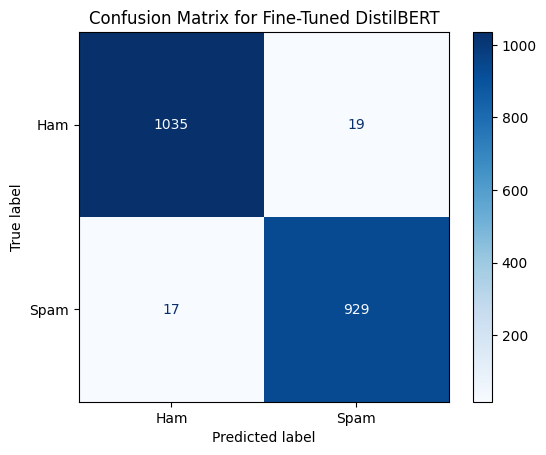

In [ ]:
# --- Define Training Arguments and Metrics ---
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

training_args = TrainingArguments(
    output_dir=DRIVE_OUTPUT_DIR,
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=f"{DRIVE_OUTPUT_DIR}/logs",
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none" # Enable to report to W&B
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


# --- Instantiate & Run Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

# Check for a previous checkpoint to resume training
latest_checkpoint = None
if os.path.isdir(training_args.output_dir):
    checkpoints = [d for d in os.listdir(training_args.output_dir) if d.startswith("checkpoint-")]
    if checkpoints:
        try:
            latest_checkpoint_num = max([int(c.split('-')[1]) for c in checkpoints])
            latest_checkpoint = os.path.join(training_args.output_dir, f"checkpoint-{latest_checkpoint_num}")
            print(f"Found checkpoint. Resuming training from: {latest_checkpoint}")
        except (ValueError, IndexError):
            print("Could not parse checkpoint numbers. Starting from scratch.")

# Main training command
trainer.train(resume_from_checkpoint=latest_checkpoint)


# --- Final Evaluation on the Held-Out Test Set ---
print("\n--- Final Evaluation on Test Set ---")
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

final_accuracy = accuracy_score(y_true, y_pred)
print(f"Final Test Accuracy: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Ham', 'Spam']))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Fine-Tuned DistilBERT")
plt.show()

Increasing:
* Max legnth from 256 to 512
* train_size from 20K to 50K
* Epochs from 2 to 10

Using device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Data split sizes: Train=36000, Validation=9000, Test=5000
Found checkpoint. Resuming training from: /content/drive/My Drive/Spam_Project_FineTuning/checkpoint-11250


Epoch,Training Loss,Validation Loss,Accuracy,F1
6,0.000000,0.136187,0.985222,0.985185
7,0.000000,0.114204,0.986889,0.986849
8,0.000000,0.125650,0.986444,0.986407
9,0.000000,0.111572,0.988000,0.987968
10,0.000000,0.123714,0.987222,0.987180



--- Final Evaluation on Test Set ---


Final Test Accuracy: 0.9860

Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.98      0.99      2635
        Spam       0.98      0.99      0.99      2365

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



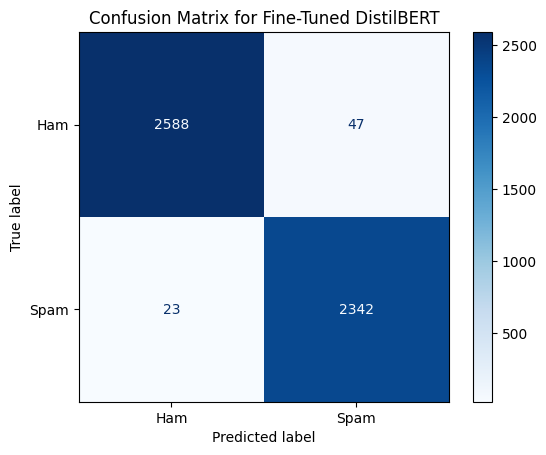

In [ ]:

# --- Prepare & Tokenize Data (with Train/Validation/Test Split) ---

df_sample, _ = train_test_split(df, train_size=50000, stratify=df["label"], random_state=42)

#  Select ONLY the columns we need BEFORE splitting.
df_clean_sample = df_sample[['text', 'label']].copy()

# Now, perform the splits on this clean DataFrame
train_val_df, test_df = train_test_split(df_sample, test_size=0.1, random_state=42, stratify=df_sample['label'])
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['label'])

# Rename 'label' to 'labels' as required by the Trainer
train_df = train_df.rename(columns={'label': 'labels'})
val_df = val_df.rename(columns={'label': 'labels'})
test_df = test_df.rename(columns={'label': 'labels'})

# Create datasets from the clean pandas DataFrames
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


print(f"Data split sizes: Train={len(train_dataset)}, Validation={len(val_dataset)}, Test={len(test_dataset)}")

# --- Define Training Arguments & Metrics ---
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

training_args = TrainingArguments(
    output_dir=DRIVE_OUTPUT_DIR,
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=f"{DRIVE_OUTPUT_DIR}/logs",
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none" # Disables reporting to services like W&B
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


# --- Instantiate & Run Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)


# Check for a previous checkpoint to resume training
latest_checkpoint = None
if os.path.isdir(training_args.output_dir):
    checkpoints = [d for d in os.listdir(training_args.output_dir) if d.startswith("checkpoint-")]
    if checkpoints:
        try:
            latest_checkpoint_num = max([int(c.split('-')[1]) for c in checkpoints])
            latest_checkpoint = os.path.join(training_args.output_dir, f"checkpoint-{latest_checkpoint_num}")
            print(f"Found checkpoint. Resuming training from: {latest_checkpoint}")
        except (ValueError, IndexError):
            print("Could not parse checkpoint numbers. Starting from scratch.")


# Main training command
trainer.train(resume_from_checkpoint=latest_checkpoint)


# --- Final Evaluation on the Held-Out Test Set ---
print("\n--- Final Evaluation on Test Set ---")
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

final_accuracy = accuracy_score(y_true, y_pred)
print(f"Final Test Accuracy: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Ham', 'Spam']))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Fine-Tuned DistilBERT")
plt.show()

Additional Metrics


--- Additional 'Count-Based' Metrics ---
Matthews Corr. Coef. (MCC): 0.9720
Cohen's Kappa:              0.9719

--- Additional 'Probability-Based' Metrics ---
ROC AUC Score:              0.9972
Log Loss:                   0.1307


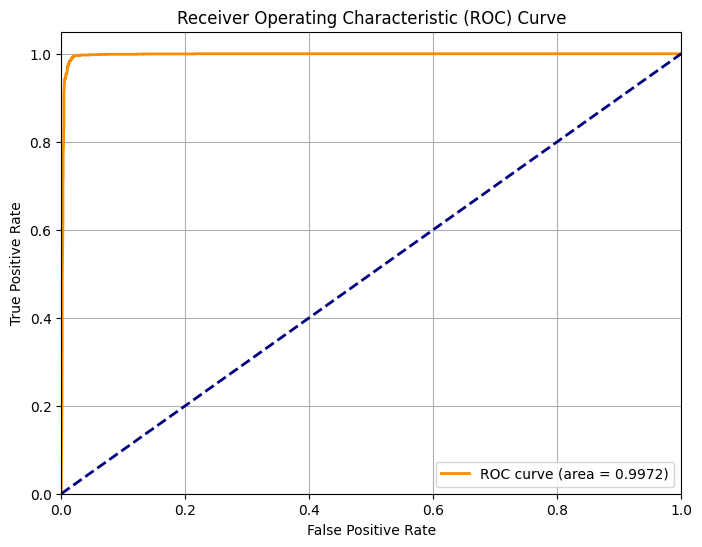

In [ ]:
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score

print("\n--- Additional 'Count-Based' Metrics ---")

# Matthews Correlation Coefficient (MCC) is good for binary classification
# +1 is a perfect prediction, 0 is random, -1 is inverse prediction.
mcc = matthews_corrcoef(y_true, y_pred)
print(f"Matthews Corr. Coef. (MCC): {mcc:.4f}")

# Cohen's Kappa
# Measures agreement between model's predictions and true labels, corrected for chance.
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa:              {kappa:.4f}")


from sklearn.metrics import roc_auc_score, roc_curve, log_loss
import matplotlib.pyplot as plt

print("\n--- Additional 'Probability-Based' Metrics ---")

# Convert raw logits to probabilities using softmax
logits = torch.tensor(predictions.predictions)
probabilities = torch.nn.functional.softmax(logits, dim=-1).numpy()

# Get the probability of the 'Spam' class (the positive class, index 1)
spam_probabilities = probabilities[:, 1]

# ROC AUC Score
# Measures the model's ability to distinguish between Ham & Spam. 1 is perfect.
roc_auc = roc_auc_score(y_true, spam_probabilities)
print(f"ROC AUC Score:              {roc_auc:.4f}")

# Log Loss
# Measures error of probability predictions (lower is better).
logloss = log_loss(y_true, probabilities)
print(f"Log Loss:                   {logloss:.4f}")

# 3. Generate and Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, spam_probabilities)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



---


**Assistance Disclosure:**

I used LLMs (Codey, ChatGPT, Gemini, Claude, Grok) for brainstorming, debugging, feedback, and improving code readability.